In [1]:
import os
import subprocess
import io
import IPython.display
import numpy as np
import PIL.Image
import torch
from models import MODEL_ZOO
from models import build_generator
from utils.visualizer import fuse_images
from utils.helper import *
import matplotlib.pyplot as plt
# Autosave every 60 s
%autosave 60
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Autosaving every 60 seconds
cuda


# Select model

Select a model from the list below. Copy the model you want to use & paste it in **MODEL_NAME**:

* 'stylegan_bedroom256'
* 'stylegan_livingroom256'
* 'stylegan_diningroom256'
* 'stylegan_kitchen256'
* 'stylegan_apartment256'
* 'stylegan_church256'
* 'stylegan_tower256'
* 'stylegan_bridge256'
* 'stylegan_restaurant256'
* 'stylegan_classroom256'
* 'stylegan_conferenceroom256'
* 'stylegan2_church256'

In [2]:
MODEL_NAME = 'stylegan_kitchen256'

In [3]:
generator = build(MODEL_NAME)
num_samples = 1
truncation = 1
truncation_layers = 3
randomize_noise = 'false'
synthesis_kwargs = dict(trunc_psi=1 - truncation,
             trunc_layers=truncation_layers,
             randomize_noise=randomize_noise)

Building generator for model `stylegan_kitchen256` ...
Finish building generator.
Loading checkpoint from `checkpoints/stylegan_kitchen256.pth` ...
Finish loading checkpoint.


# Choose an anchor image

To choose the image you want to send as an anchor, generate many images and select the one you think looks best.

**Change the following variables:**

* **START_SEED**: The first image.
* **END_SEED**: The last image.

*Note: Make sure that START_SEED < END_SEED*

In [4]:
START_SEED = 0
END_SEED = 10

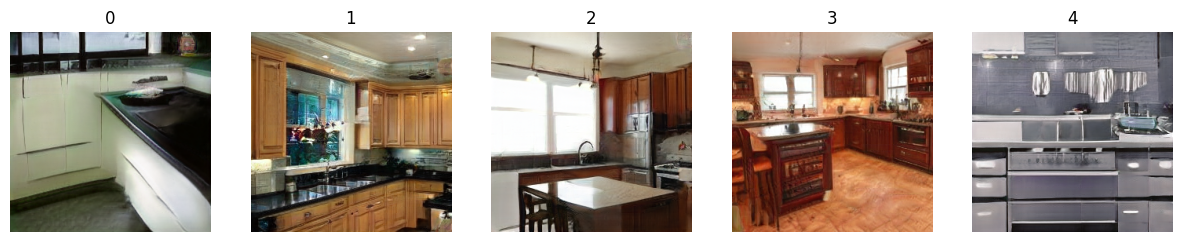

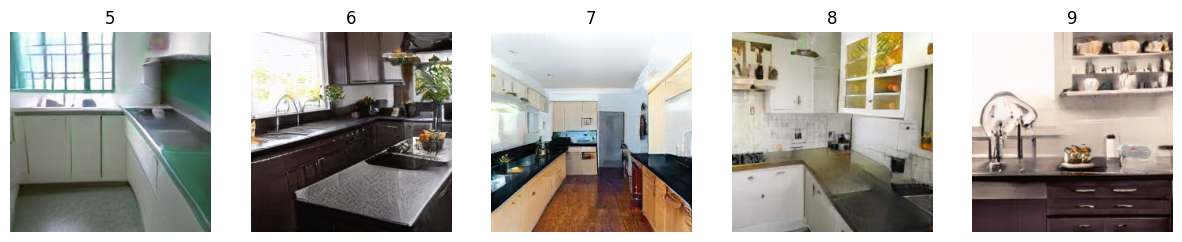

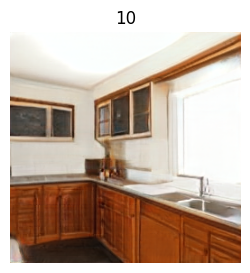

In [5]:
images, seeds = [], []
for s in range(START_SEED, END_SEED+1):
  w = synthesize(generator, num_samples, synthesis_kwargs, seed=s)
  image = postprocess(generator(w)['image'])[0] 
  images.append(image)
  seeds.append(s)

  if len(images) == 5:
      plt.figure(figsize=(15, 3)) 
      for i, (img, s) in enumerate(zip(images, seeds)):
          plt.subplot(1, 5, i+1)
          plt.title(s)
          plt.imshow(img)
          plt.axis('off')
      plt.show()
      images, seeds = [], []

remaining = len(images)
if images:
  plt.figure(figsize=(15, 3))
  for i, (img, s) in enumerate(zip(images, seeds)):
    plt.subplot(1, remaining, i+1)
    plt.title(s)
    plt.imshow(img)
    plt.axis('off')
  plt.show()

# Choose a noise level & generate pairmates

We can generate different pairmates by adding varying the amount of noise that is added to the original image. Choose an image that you want to add noise to and select the range of noise levels you want to add. 

**Change the following variables:**

* **CHOSEN_SEED**: The seed that corresponds to the best-looking image above. This will serve as your "anchor."
* **NOISE_SCALE_STEP:** The number of noise steps you want to test (e.g. NOISE_SCALE_UPPER=10, incrementally adds noise so that you get 10 image panels).

**Optional changes:**
* **NOISE_SCALE_UPPER:** The upper bound for the noise scale. This is the maximum noise that can be added to the anchor. (*DEFAULT*=1)
* **NOISE_SCALE_LOWER:** The lower bound of the noise scale. This is the minimum noise that can be added to the anchor. (*DEFAULT*=0)
* **NOISE_SEED**: The specific type of random noise. By changing this, you change the random noise that is being added to the anchor image. This won't affect the final images that much. (*DEFAULT*=0)
* **SLERP_RANGE**: The markers along the range [1, 10] where you want to capture an image. In other words, the intervals for the slerp function. 

In [6]:
# Variables to change
CHOSEN_SEED = 98
NOISE_SCALE_STEP = 5

# Optional
NOISE_SCALE_UPPER = 1
NOISE_SCALE_LOWER = 0
NOISE_SEED = 0
SLERP_UPPER = 1
SLERP_RANGE = [1, 3, 4, 5, 6, 7, 8, 10]

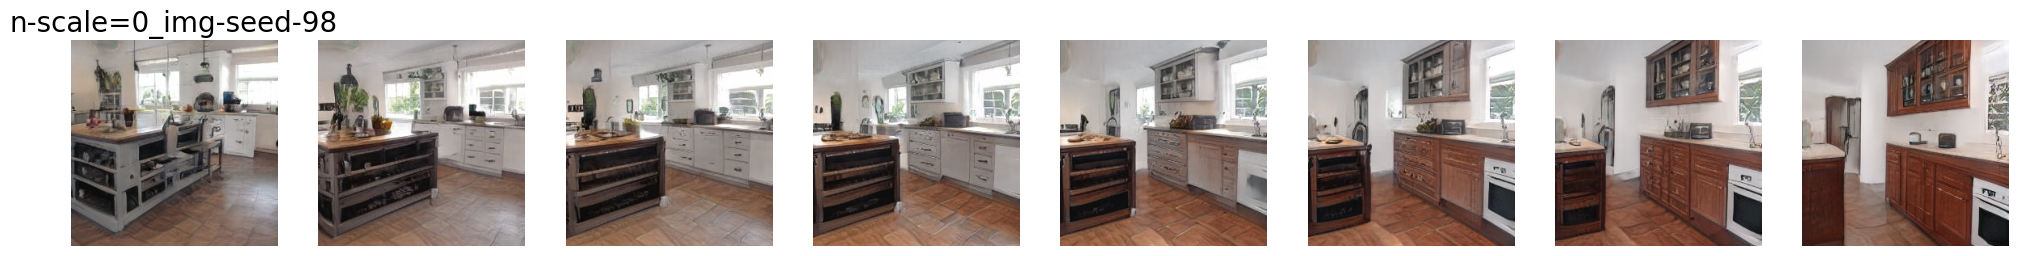

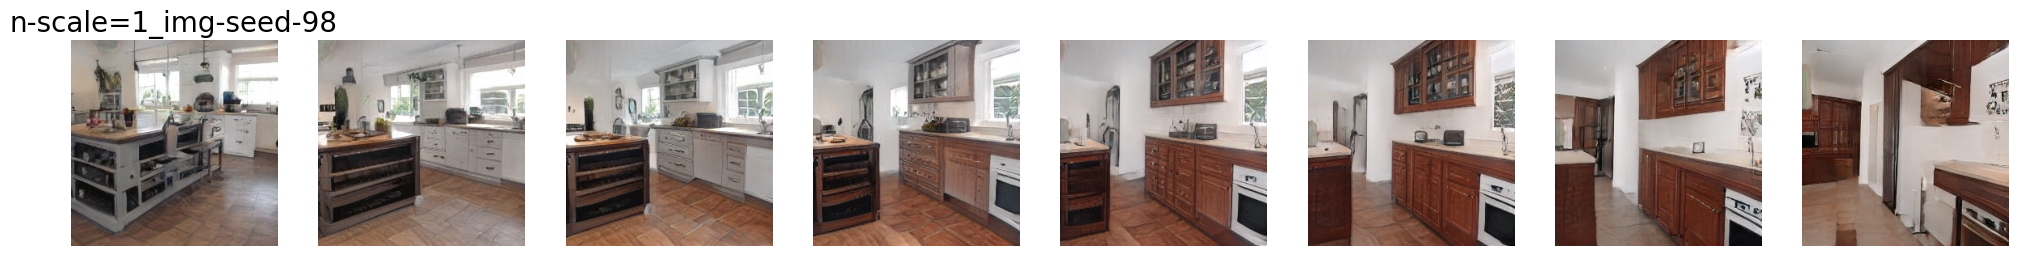

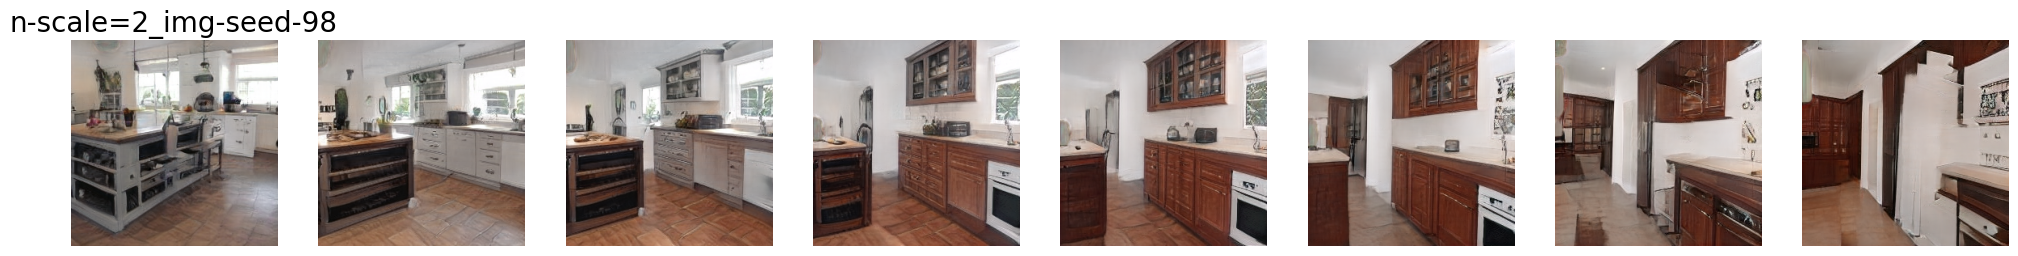

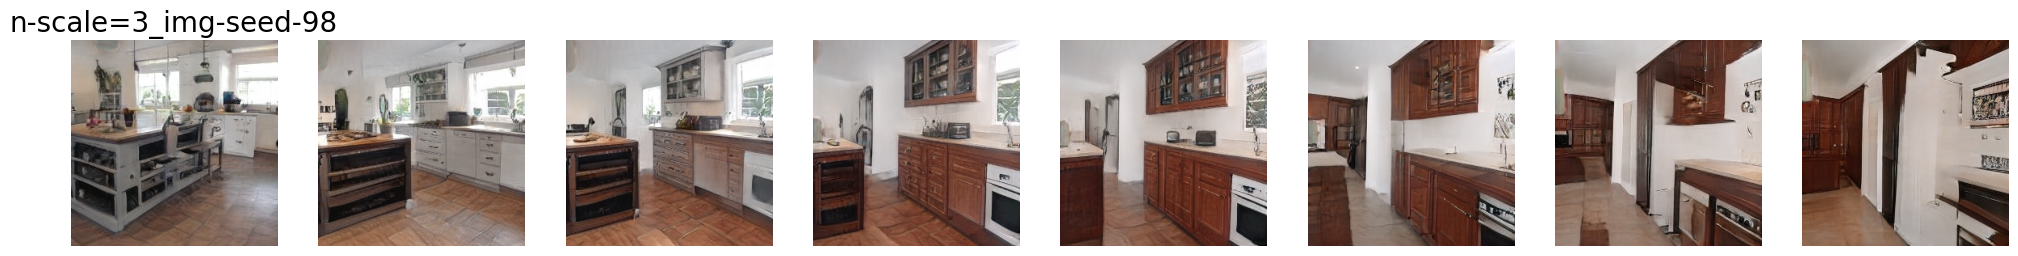

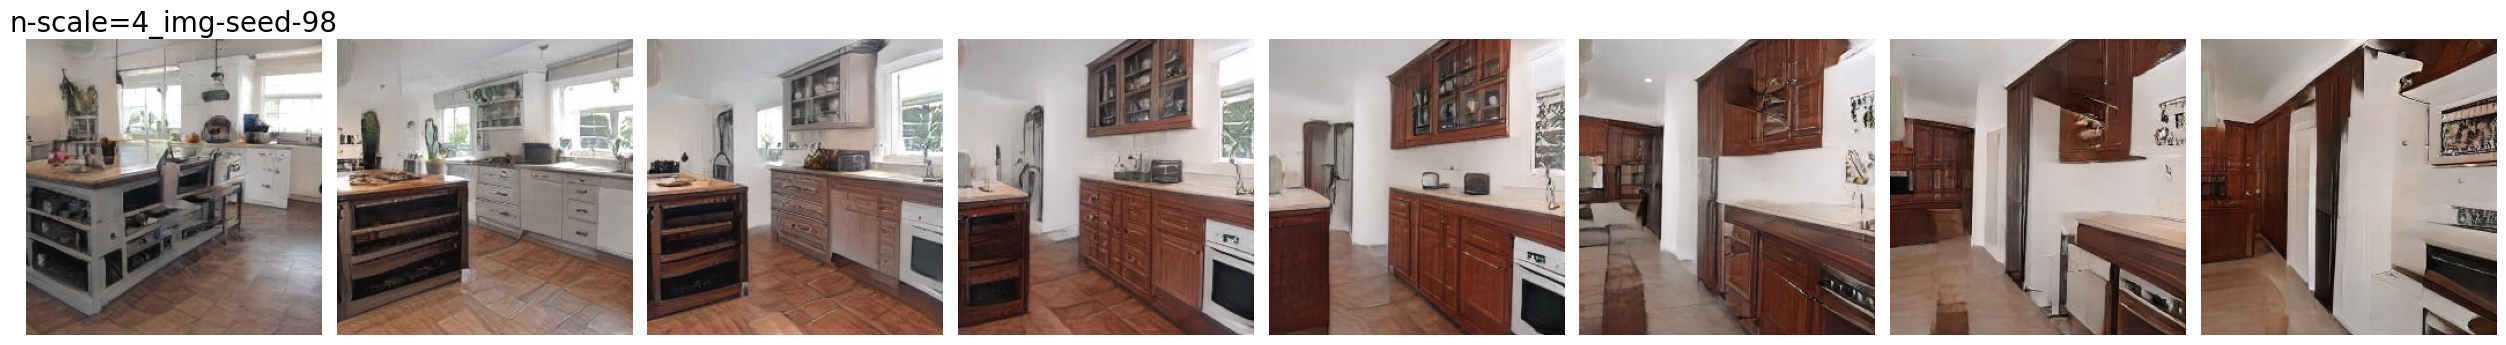

In [7]:
NOISE_STEP = 1/(NOISE_SCALE_STEP-1)
NOISE_UPPER = NOISE_SCALE_UPPER + 1.5*NOISE_STEP
NOISE_LOWER = NOISE_SEED + NOISE_STEP
noise_scales = np.arange(NOISE_LOWER, NOISE_UPPER, NOISE_STEP)
slerp_range = [(i-1)/9 for i  in SLERP_RANGE] 

for n, noise_scale in enumerate(noise_scales):
    torch.manual_seed(NOISE_SEED)
    w_1 = synthesize(generator, num_samples, synthesis_kwargs, seed=CHOSEN_SEED)
    w_noise = w_1 + torch.randn_like(w_1) * noise_scale
    images = []
    plt.figure(figsize=(25, 15))
    for i, t in enumerate(slerp_range):
        img = postprocess(generator(slerp(w_1, w_noise, t), 1)['image'])[0]
        images.append(img)
        plt.subplot(1, len(slerp_range), i+1)
        plt.imshow(img)
        if i == 0:
            plt.title(f"n-scale={n}_img-seed-{CHOSEN_SEED}", fontsize=20)
        plt.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout()
plt.show()

# Save the best-looking pairmates

Hopefully, you have found some pairmates you like! Now, it's time to save them.

**Change the following variables:**

* **CHOSEN_SEED**: This "anchor" image. Same as the one you used above. 
* **BEST_NOISE:** The noise scale that generated the best images above. **Choose the number in the title.**
* **SAVE_ALL**: True, if you want to save all images.
* **SAVE_PANEL**: True, if you want to save the panel.
* **SCRATCH**: Your scratch folder ("/scratch/gpfs/$NETID")

*NOTE:* Make sure you run the cells above before you run the cells below. The cells above determine the values of variables you will need to save the image (e.g. SLERP_RANGE, NOISE_SEED, etc.)

In [8]:
# Variables to change
CHOSEN_SEED = 98
BEST_NOISE = 1
SAVE_ALL = True
SAVE_PANEL = True
SCRATCH = "/scratch/gpfs/al8996"

Saving all images at: /scratch/gpfs/al8996/genforce/noise/stylegan_kitchen256/all_images
Saving panel at: /scratch/gpfs/al8996/genforce/noise/stylegan_kitchen256/panels


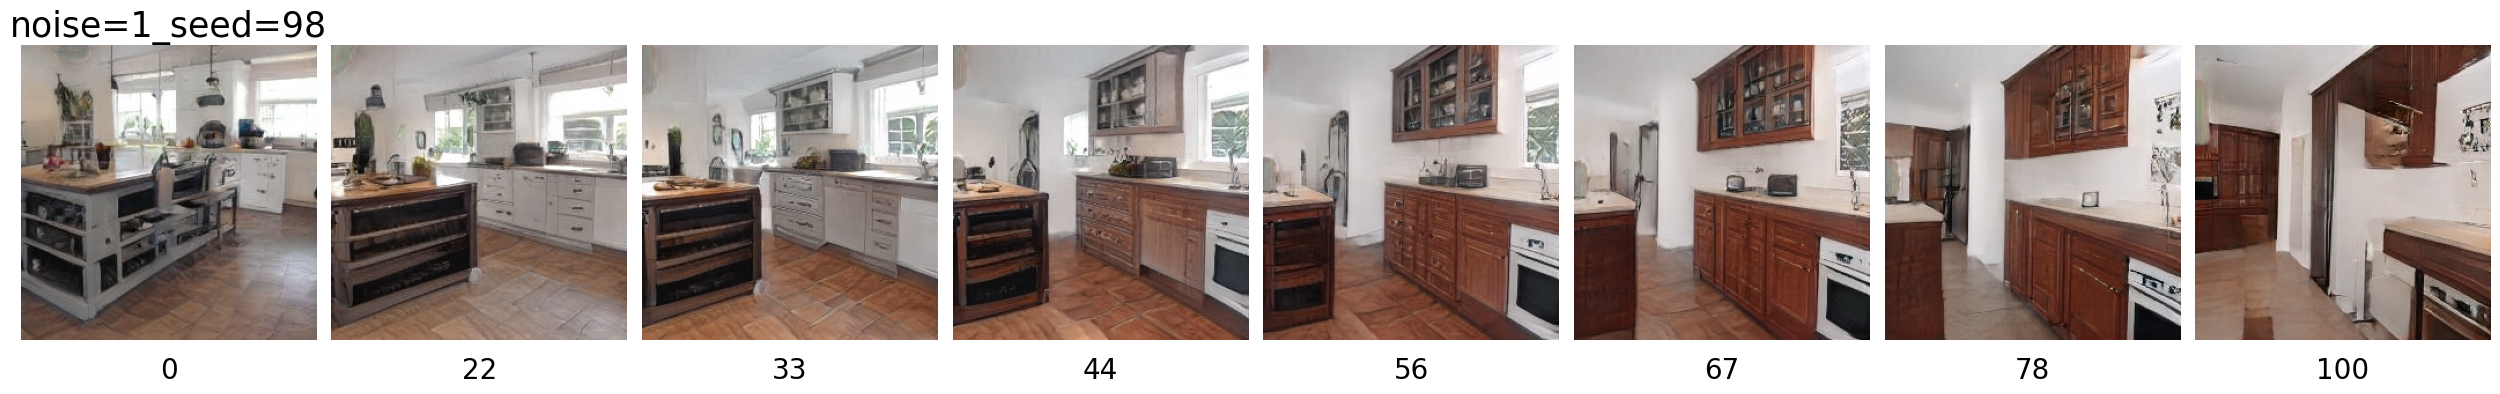

In [9]:
outdir = os.path.join(SCRATCH, "genforce", "noise", MODEL_NAME)
BEST_NOISE_SCALE = noise_scales[BEST_NOISE]

torch.manual_seed(NOISE_SEED)
w_1 = synthesize(generator, num_samples, synthesis_kwargs, seed=CHOSEN_SEED)
w_noise = w_1 + torch.randn_like(w_1) * BEST_NOISE_SCALE
images = []
plt.figure(figsize=(25, 15))

for i, t in enumerate(slerp_range):
    img = postprocess(generator(slerp(w_1, w_noise, t), 1)['image'])[0]
    images.append(img)
    plt.subplot(1, len(slerp_range), i+1)
    plt.imshow(img)
    label = f"{int(round(t, 2)*100)}"
    plt.text(0.5, -0.1, label, ha='center', va='center', transform=plt.gca().transAxes, fontsize=20)
    if i == 0:
        outdir_images = os.path.join(outdir, "all_images")
        os.makedirs(outdir_images, exist_ok=True)
        print(f"Saving all images at: {outdir_images}")
        plt.title(f"noise={BEST_NOISE}_seed={CHOSEN_SEED}", fontsize=25)
    if SAVE_ALL: 
        outfn = f"seed={CHOSEN_SEED}_slerp={int(round(t, 2)*100)}_noise-seed={NOISE_SEED}_noise-scale={int(round(BEST_NOISE_SCALE, 2)*100)}.png"
        img = img[np.newaxis, :, :, :]
        img = save_img(img)
        img.save(os.path.join(outdir_images, outfn))
    plt.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout()
if SAVE_PANEL:
    outdir_panels = os.path.join(outdir, "panels")
    os.makedirs(outdir_panels, exist_ok=True)
    print(f"Saving panel at: {outdir_panels}")
    outfn = f"seed={CHOSEN_SEED}_slerp=all_noise-seed={NOISE_SEED}_noise-scale={int(round(BEST_NOISE_SCALE, 2)*100)}.png"
    plt.savefig(os.path.join(outdir_panels, outfn))
plt.show()

# Method 2: Choose two anchor images.

We can generate different pairmates by adding varying the amount of noise that is added to the original image. Choose an image that you want to add noise to and select the range of noise levels you want to add. 

**Change the following variables:**

* **SEED_1**: The first anchor image.
* **SEED_2**: The second anchor image. This is the image you want to "move" towards. 
* **SAVE_ALL**: True, if you want to save all images.
* **SAVE_PANEL**: True, if you want to save the panel.

**Optional changes:**
* **SLERP_RANGE**: The markers along the range [1, 10] where you want to capture an image. In other words, the intervals for the slerp function.

In [10]:
# Variables to change
SEED_1 = 98
SEED_2 = 56
SAVE_ALL = True
SAVE_PANEL = True
SCRATCH = "/scratch/gpfs/al8996"

# Optional
SLERP_RANGE = [1, 3, 4, 5, 6, 7, 8, 10]

Saving all images at: /scratch/gpfs/al8996/genforce/anchors/stylegan_kitchen256/all_images
Saving panel at: /scratch/gpfs/al8996/genforce/anchors/stylegan_kitchen256/panels


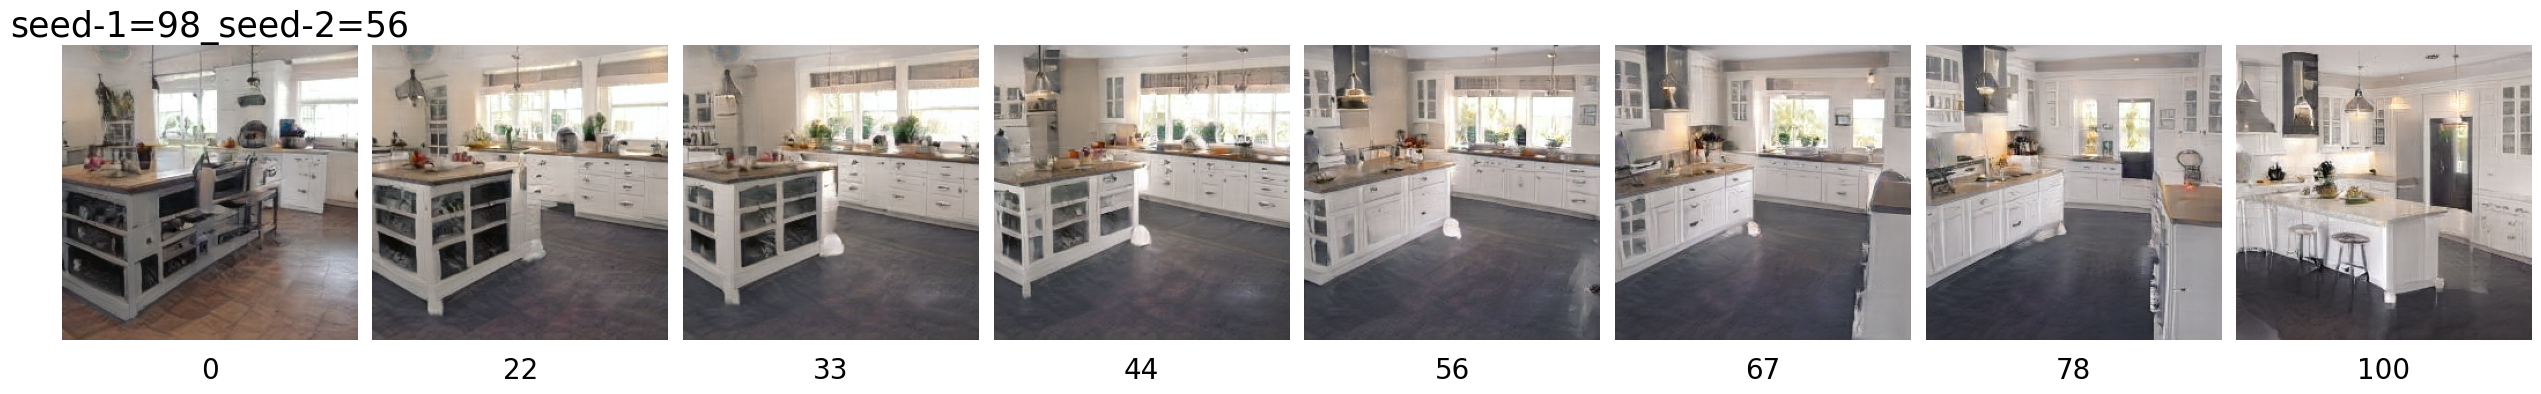

In [11]:
outdir = os.path.join(SCRATCH, "genforce", "anchors", MODEL_NAME)
slerp_range = [(i-1)/9 for i in SLERP_RANGE]

w_1 = synthesize(generator, num_samples, synthesis_kwargs, seed=SEED_1)
w_2 = synthesize(generator, num_samples, synthesis_kwargs, seed=SEED_2)

images = []
plt.figure(figsize=(25, 15))
for i, t in enumerate(slerp_range):
    img = postprocess(generator(slerp(w_1, w_2, t), 1)['image'])[0]
    images.append(img)
    plt.subplot(1, len(slerp_range), i+1)
    plt.imshow(img)
    label = f"{int(round(t, 2)*100)}"
    plt.text(0.5, -0.1, label, ha='center', va='center', transform=plt.gca().transAxes, fontsize=20)
    if i == 0:
        outdir_images = os.path.join(outdir, "all_images")
        os.makedirs(outdir_images, exist_ok=True)
        print(f"Saving all images at: {outdir_images}")
        plt.title(f"seed-1={SEED_1}_seed-2={SEED_2}", fontsize=25)
    if SAVE_ALL: 
        outfn = f"seed-1={SEED_1}_seed-2={SEED_2}_slerp={int(round(t, 2)*100)}.png"
        img = img[np.newaxis, :, :, :]
        img = save_img(img)
        img.save(os.path.join(outdir_images, outfn))
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout()
if SAVE_PANEL:
    outdir_panels = os.path.join(outdir, "panels")
    os.makedirs(outdir_panels, exist_ok=True)
    print(f"Saving panel at: {outdir_panels}")
    outfn = f"seed_1={SEED_1}_seed_2={SEED_2}_slerp=all.png"
    plt.savefig(os.path.join(outdir_panels, outfn))
plt.show()